- __Import các thư viện cần thiết__

- __findspark.init()__: khởi tạo Spark. Nó cho phép Python tìm thấy cài đặt Spark trên hệ thống và đưa Spark vào môi trường làm việc của Python.

- __spark = SparkSession.builder.appName('CardioGoodFitness').getOrCreate()__: khởi tạo một SparkSession, một phiên làm việc Spark, với tên ứng dụng là 'CardioGoodFitness'

- __import warnings__: cho phép người dùng đưa ra cảnh báo khi có lỗi xảy ra trong quá trình thực thi.

- __warnings.filterwarnings('ignore')__: được sử dụng để tắt cảnh báo khi có lỗi xảy ra trong quá trình thực thi, để giảm sự xáo trộn của output và giúp tập trung vào thông tin quan trọng hơn.

In [37]:
import findspark
findspark.init()


import pyspark
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# Tạo SparkSession
spark = SparkSession.builder.appName('CardioGoodFitness').getOrCreate()

import warnings
warnings.filterwarnings('ignore')

- __df = spark.read.csv('CardioGoodFitness.csv', header=True, inferSchema=True)__: đọc tập tin CSV CardioGoodFitness.csv vào một Spark DataFrame, header=True được sử dụng để báo cho Spark có hàng đầu tiên chứa tên cột, inferSchema=True tự động xác định kiểu dữ liệu của các cột.

- __df.printSchema()__:  hiển thị thông tin về dữ liệu, bao gồm tên cột và kiểu dữ liệu của chúng, cũng như một số thông tin khác về cấu trúc của DataFrame

In [38]:
# Đọc tập tin CSV
df = spark.read.csv('CardioGoodFitness.csv', header=True, inferSchema=True)

# Hiển thị thông tin về dữ liệu
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Usage: integer (nullable = true)
 |-- Fitness: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Miles: integer (nullable = true)



- __df.show(5)__: Hiện 5 dòng của dữ liệu 

In [39]:
df.show(5)

+-------+---+------+---------+-------------+-----+-------+------+-----+
|Product|Age|Gender|Education|MaritalStatus|Usage|Fitness|Income|Miles|
+-------+---+------+---------+-------------+-----+-------+------+-----+
|  TM195| 18|  Male|       14|       Single|    3|      4| 29562|  112|
|  TM195| 19|  Male|       15|       Single|    2|      3| 31836|   75|
|  TM195| 19|Female|       14|    Partnered|    4|      3| 30699|   66|
|  TM195| 19|  Male|       12|       Single|    3|      3| 32973|   85|
|  TM195| 20|  Male|       13|    Partnered|    4|      2| 35247|   47|
+-------+---+------+---------+-------------+-----+-------+------+-----+
only showing top 5 rows



- __df = df.withColumn("Product", col("Product").cast("string")) \
       .withColumn("Gender", col("Gender").cast("string")) \
       .withColumn("MaritalStatus", col("MaritalStatus").cast("string"))__ : thực hiện ép kiểu dữ liệu của các cột __Product__, __Gender__ và __MaritalStatus__ thành kiểu string

- __df.printSchema()__: hiển thị kiểu dữ liệu của từng cột và tên của các cột

In [40]:
df = df.withColumn("Product", col("Product").cast("string")) \
       .withColumn("Gender", col("Gender").cast("string")) \
       .withColumn("MaritalStatus", col("MaritalStatus").cast("string"))

# Hiển thị schema của DataFrame
df.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Usage: integer (nullable = true)
 |-- Fitness: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Miles: integer (nullable = true)



- Đếm số lượng giá trị null trong mỗi cột của DataFrame

- Input: Dữ liệu của Dataframe
- Output: Số lượng giá trị null trong mỗi cột tương ứng với tên cột

In [41]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-------+---+------+---------+-------------+-----+-------+------+-----+
|Product|Age|Gender|Education|MaritalStatus|Usage|Fitness|Income|Miles|
+-------+---+------+---------+-------------+-----+-------+------+-----+
|      0|  0|     0|        0|            0|    0|      0|     0|    0|
+-------+---+------+---------+-------------+-----+-------+------+-----+



- Sử lý dữ liệu trùng trong tập dữ liệu CardioGoodFitness

- Input: Dữ liệu của toàn cột trong DataFrame

- Output: Thông tin số cột đã được xóa

In [42]:
# Đếm số lượng bản ghi sau khi loại bỏ các bản ghi trùng lặp
print("Number of DataFrame: ", df.count())
print("Number of rows after removing duplicates: ", df.dropDuplicates().count())

Number of DataFrame:  180
Number of rows after removing duplicates:  180


- Bảng tóm tắt các thông tin thống kê chính về các cột của DataFrame

- Input: Dữ liệu của Dataframe
- Output: Bảng tóm tắt thông tin thông kê của dataframe

In [43]:
df.summary().show()

+-------+-------+------------------+------+------------------+-------------+------------------+------------------+-----------------+------------------+
|summary|Product|               Age|Gender|         Education|MaritalStatus|             Usage|           Fitness|           Income|             Miles|
+-------+-------+------------------+------+------------------+-------------+------------------+------------------+-----------------+------------------+
|  count|    180|               180|   180|               180|          180|               180|               180|              180|               180|
|   mean|   null|28.788888888888888|  null|15.572222222222223|         null|3.4555555555555557| 3.311111111111111|53719.57777777778|103.19444444444444|
| stddev|   null| 6.943498135399797|  null|1.6170548978065555|         null|1.0847970343962434|0.9588685656193114|16506.68422623862| 51.86360466180932|
|    min|  TM195|                18|Female|                12|    Partnered|            

# __Graph 1: Pie chart of Product Sales__

- __product_counts = df.groupBy('Product').agg(count('*').alias('count'))__ : tính toán số lượng sản phẩm bán được cho mỗi loại, Cột __count__ biểu thị số lượng sản phẩm bán được

- __total_count = product_counts.agg(sum('count')).collect()[0][0]__ : tính tổng số lượng sản phẩm bán được, kết quả được lưu trữ trong biến __total_count__

# __Ver 1: chuyển Pandas vẽ__

- Input: Dữ liệu cột __Product__

- Output: Biểu đồ tròn thể hiện phần trắm bán được của sản phẩm

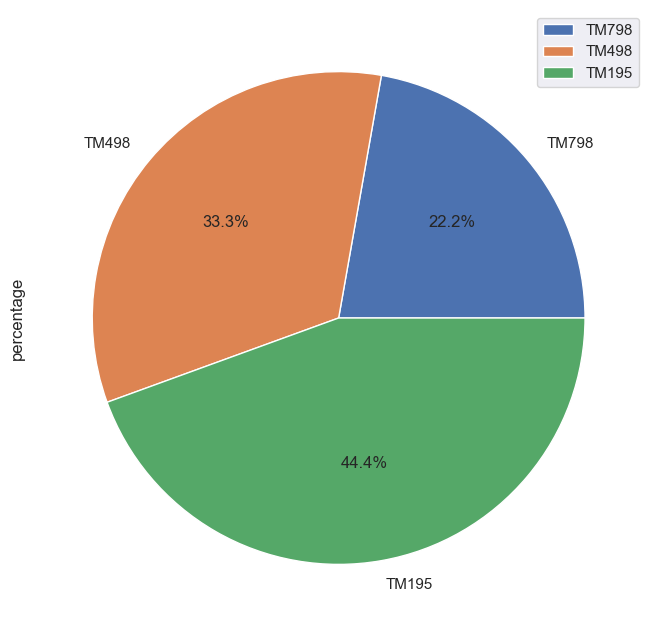

In [44]:
# Tính toán số lượng sản phẩm bán được cho mỗi loại sản phẩm
product_counts = df.groupBy('Product').agg(count('*').alias('count'))

# Tính toán tổng số lượng sản phẩm bán được
total_count = product_counts.agg(sum('count')).collect()[0][0]

# Tính toán tỷ lệ phần trăm của mỗi loại sản phẩm
product_counts = product_counts.withColumn('percentage', col('count')/total_count*100)

# Vẽ biểu đồ pie cho cột 'Product'
product_counts.select('Product', 'percentage').toPandas().plot.pie(y='percentage', labels=product_counts.select('Product').toPandas()['Product'], autopct='%1.1f%%', figsize=(8, 8))

plt.show()

# __Ver2: Vẽ trực tiếp không chuyển qua Pandas__

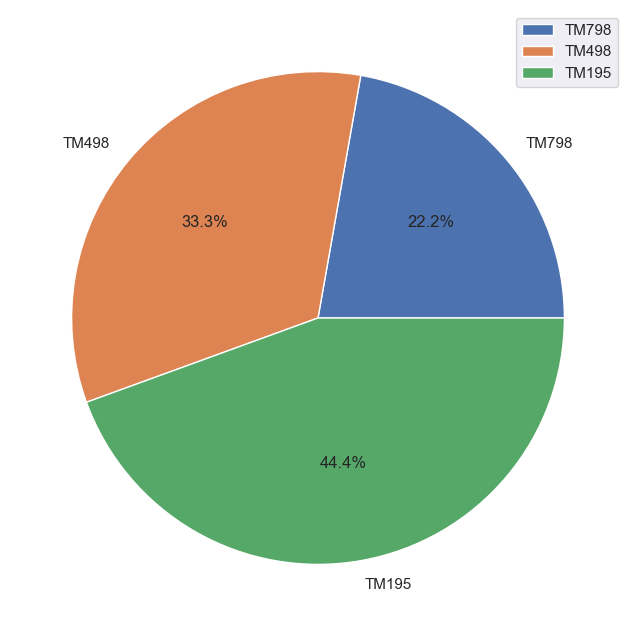

In [45]:
product_percentages = product_counts.select('Product', 'percentage').collect()
product_names = [row['Product'] for row in product_percentages]
percentages = [row['percentage'] for row in product_percentages]

# Vẽ biểu đồ pie
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=product_names, autopct='%1.1f%%')
plt.legend()
plt.show()

# __Graph 2: Purchase count gender wise__

- __purchase_count = df.groupBy('Product', 'Gender').count().groupBy('Product').pivot('Gender').agg({'count': 'sum'}).fillna(0)__ : Tính toán số lượng sản phẩm được mua theo giới tính và loại sản phẩm, và tính tổng số lượng cho từng nhóm

- __purchase_count_pd = purchase_count.toPandas()__ : Chuyển đổi kết quả trên thành đối tượng Pandas

- __purchase_count_pd = purchase_count_pd.assign(total=purchase_count_pd.select_dtypes(include='number').sum(axis=1)).sort_values(by='total', ascending=False)__: Tính tổng số lượng sản phẩm được mua cho mỗi loại sản phẩm bằng cách thêm một cột mới, tính tổng các cột kiểu số và sắp xếp theo thứ tự giảm dần của tổng số lượng

# __Ver 1: Dùng Matplotlib vẽ__ 

- Input: Dữ liệu cột __Product__ và __Gender__

- Output: Biểu đồ thể hiện sản phẩm mua theo giới tính

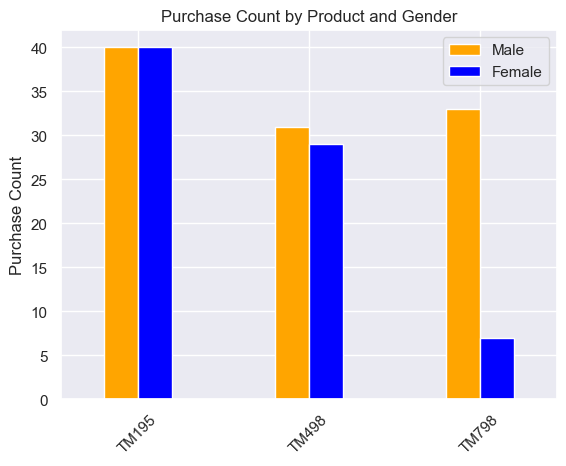

In [46]:
# Tính toán số lượng sản phẩm được mua theo giới tính và loại sản phẩm
purchase_count = df.groupBy('Product', 'Gender').count().groupBy('Product').pivot('Gender').agg({'count': 'sum'}).fillna(0)

# Chuyển đổi DataFrame thành đối tượng Pandas
purchase_count_pd = purchase_count.toPandas()

# Sắp xếp theo tổng số lượng sản phẩm được mua
purchase_count_pd = purchase_count_pd.assign(total=purchase_count_pd.select_dtypes(include='number').sum(axis=1)).sort_values(by='total', ascending=False)

# Vẽ biểu đồ cột đa biến cho số lượng sản phẩm được mua theo giới tính và loại sản phẩm
ax = purchase_count_pd.plot(kind='bar', y=['Male', 'Female'], color=['orange', 'blue'], width=0.4, position=0.5)

# Cấu hình trục x, y và tiêu đề
ax.set_xticklabels(purchase_count_pd['Product'], rotation=45)
ax.set_ylabel("Purchase Count")
ax.set_title("Purchase Count by Product and Gender")

# Hiển thị biểu đồ
plt.show()

# __Ver 2: Dùng Seaborn vẽ__ 

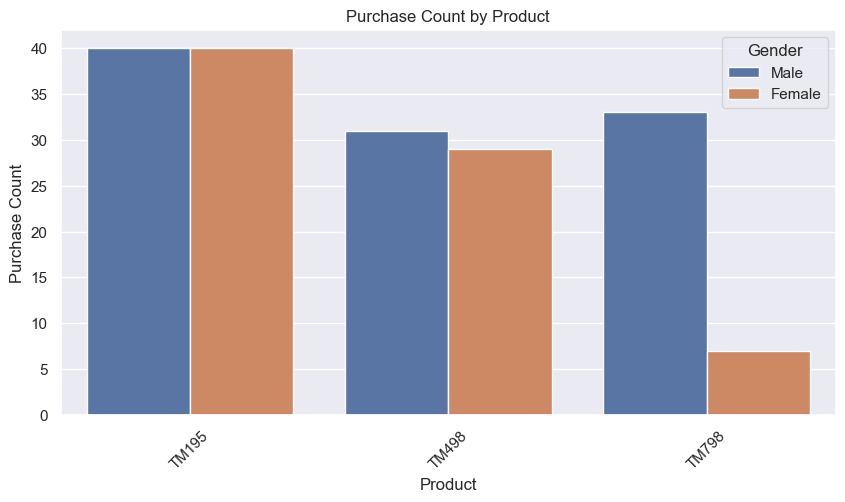

In [47]:
fig = plt.figure(figsize = (10,5))

# Vẽ biểu đồ cột cho số lượng sản phẩm được mua theo loại sản phẩm
sns.countplot (x= "Product", hue="Gender", data=df.toPandas())
plt.xticks(rotation=45)

# Cấu hình trục y và tiêu đề
plt.ylabel("Purchase Count")
plt.title("Purchase Count by Product")

plt.show()

# __Graph 3: Average number of miles for each product__

- __avg_miles_df = df.groupby("Product").agg(F.avg("Miles").alias("Average Miles"))__ : Group by theo cột 'Product' và tính trung bình của cột 'Miles'

- __avg_miles_pandas_df = avg_miles_df.toPandas()__ : Chuyển đổi PySpark DataFrame thành Pandas DataFrame

# __Ver 1: Chuyển Pandas vẽ__

- Input: Dữ liệu cột Product và Miles

- Output: Biểu đồ thể hiện tương quan của mỗi sản phẩm

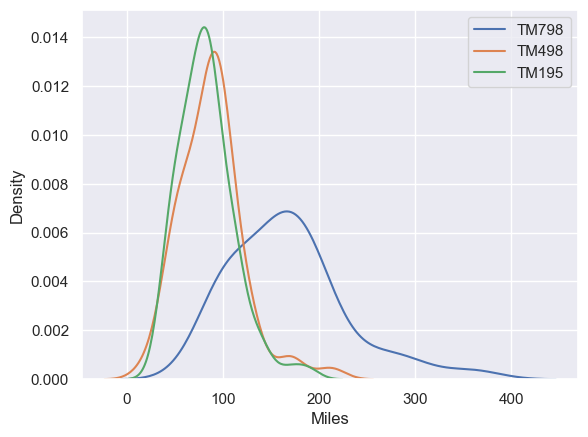

In [48]:
# Group by product and tính toán trung bình miles
avg_miles_df = df.groupby("Product").agg(F.avg("Miles").alias("Average Miles"))

# Convert PySpark DataFrame to Pandas DataFrame
avg_miles_pandas_df = avg_miles_df.toPandas()

# KDE cho mỗi sản phẩm
sns.set_theme()
for product in avg_miles_pandas_df["Product"]:
    sns.kdeplot(data=df.filter(df["Product"] == product).select("Miles").toPandas(),
                x="Miles", label=product)

# Show plot
plt.legend()
plt.show()

# Ver 2: Không chuyển pandas

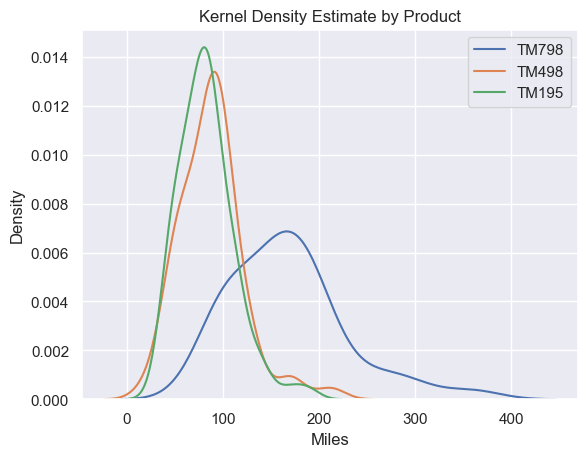

In [49]:
# Vẽ biểu đồ KDE cho mỗi sản phẩm
sns.set_theme()
for row in avg_miles_df.collect():
    product = row["Product"]
    avg_miles = row["Average Miles"]
    product_miles = df.filter(df["Product"] == product).select("Miles")

    # Chuyển đổi cột Miles thành mảng numpy
    miles_arr = np.array(product_miles.rdd.map(lambda x: x[0]).collect())

    # Vẽ biểu đồ KDE
    sns.kdeplot(data=miles_arr, label=product)

# Cấu hình trục x và tiêu đề
plt.xlabel("Miles")
plt.title("Kernel Density Estimate by Product")

# Hiển thị biểu đồ
plt.legend()
plt.show()

# __Graph 4: Income Range of customers__

- __income_df = df.select(col("Income"))__ : Lấy dữ liệu của cột __Income__

- __income_pd = income_df.toPandas()__: chuyển dữ liệu sang pandas

# __Ver 1: chuyển Pandas vẽ__

- Input: Dữ liệu cột Income

- Output: biểu đồ Box thể hiện tương quan của cột Income

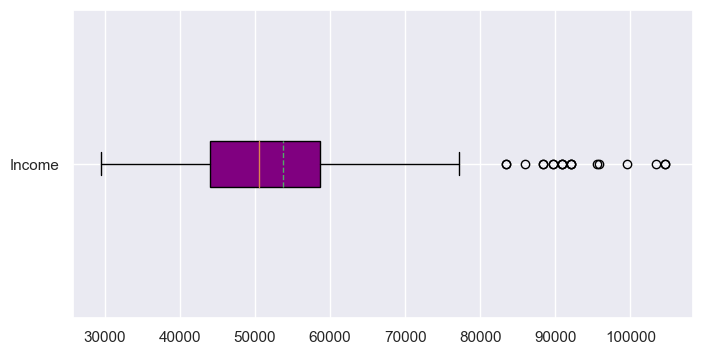

In [50]:
# Lấy dữ liệu cột "Income" dưới dạng DataFrame
income_df = df.select(col("Income"))

# Chuyển Pandas
income_pd = income_df.toPandas()

# Vẽ box plot
sns.set_theme()
fig, axs = plt.subplots(figsize=(8, 4))
axs.boxplot(income_pd["Income"], vert=False, showmeans=True, meanline=True, 
            labels=["Income"], patch_artist=True, boxprops=dict(facecolor="purple"))
plt.show()


# __Ver 2: Vẽ trực tiếp không chuyển Pandas__

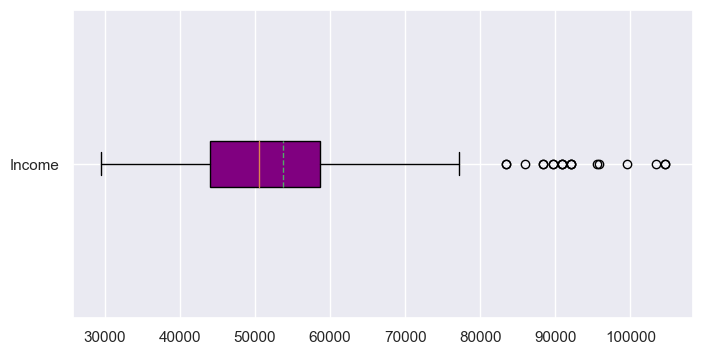

In [51]:
# Vẽ box plot
fig, axs = plt.subplots(figsize=(8, 4))
axs.boxplot(df.select("Income").rdd.flatMap(lambda x: x).collect(), vert=False,       showmeans=True, meanline=True, 
            labels=["Income"], patch_artist=True, boxprops=dict(facecolor="purple"))
plt.show()


# __Graph 5: Relation of income with age, product and usage__

- __sns.relplot(x="Age", y="Income", hue="Product", size="Usage",
            sizes=(40, 400), alpha=.5, palette="plasma",
            height=6, data=df.toPandas()).set(title='INCOME BY AGE, PRODUCT AND USAGE')__ : vẽ biểu đồ với trục x là __Age__ còn y là __Income__, __hue__ để phân loại dữ liệu theo product __df.toaPandas()__ để chuyển dữ liệu sang Pandas

- __Ver 1:__ Dùng __replot()__ vẽ

- Input: Dữ liệu cột Age và Income
- Output: Biểu đồ thể hiện sự tương quan của dữ liệu 2 cột

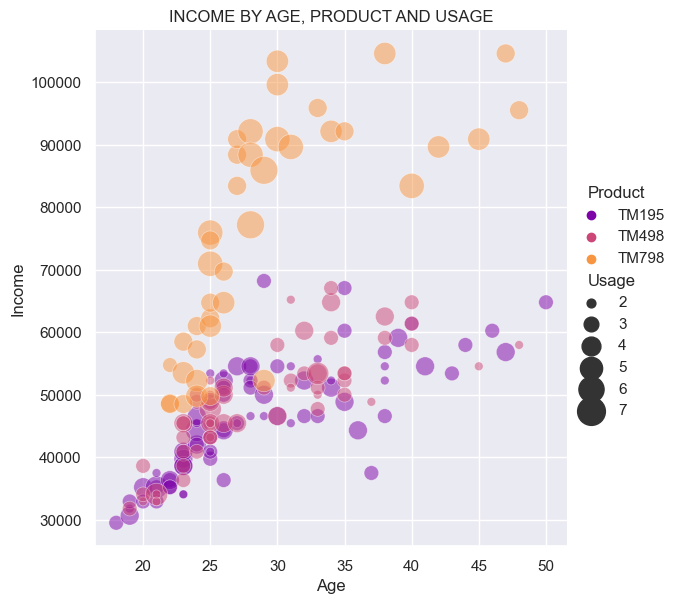

In [52]:
sns.relplot(x="Age", y="Income", hue="Product", size="Usage",
            sizes=(40, 400), alpha=.5, palette="plasma",
            height=6, data=df.toPandas()).set(title='INCOME BY AGE, PRODUCT AND USAGE')

plt.show()

# __Ver 2: Dùng Matplotlib vẽ__

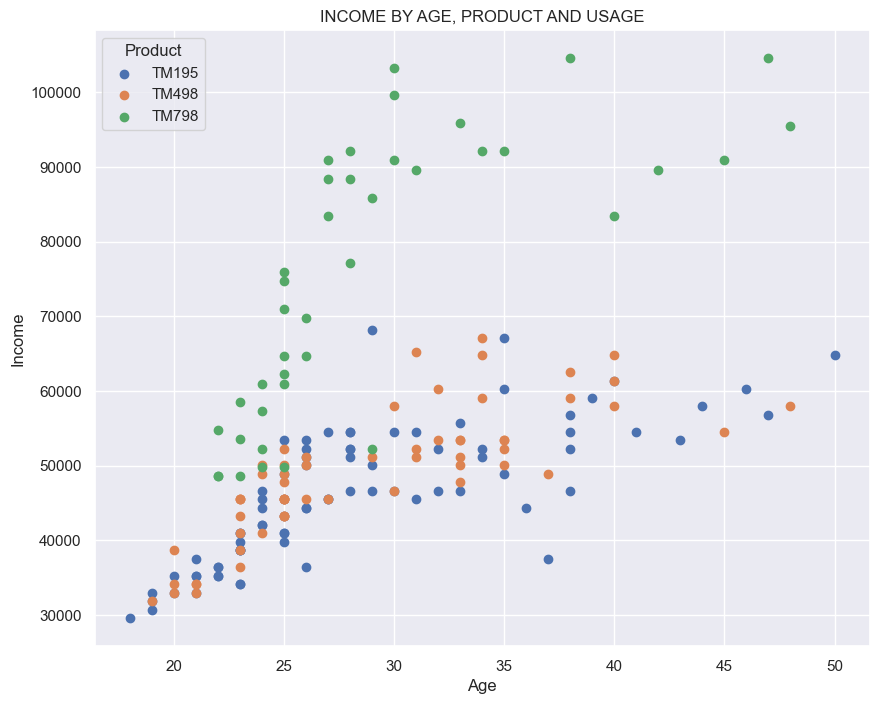

In [53]:
# Chuyển Pandas
df_pandas = df.select('Age', 'Income', 'Product', 'Usage').toPandas()

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
for product, product_data in df_pandas.groupby('Product'):
    ax.scatter(product_data['Age'], product_data['Income'], label=product)

ax.set_title('INCOME BY AGE, PRODUCT AND USAGE')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.legend(title='Product')

plt.show()

# __Ver 3:__ Dùng __scatterplot()__ vẽ

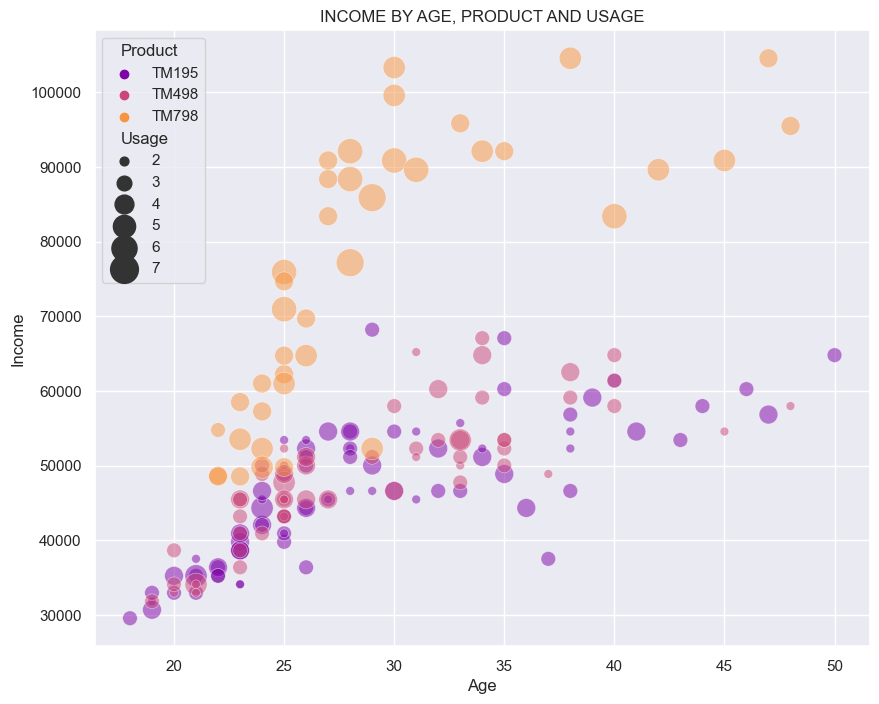

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x="Age", y="Income", hue="Product", size="Usage",
                sizes=(40, 400), alpha=.5, palette="plasma",
                data=df.toPandas(), ax=ax)

ax.set_title('INCOME BY AGE, PRODUCT AND USAGE')
plt.show()

# __Correlation Analysis__

- __cols = [col for col in df.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]]__: Lấy các dữ liệu của các cột không thuộc __["Product", "Gender", "MaritalStatus", "Cardio"]__

- __assembler = VectorAssembler(inputCols=cols, outputCol="features")__ : Tạo một cột vector mới từ các cột được chọn

- __corr_matrix = Correlation.corr(df_vector, "features").head()[0]__ : tính toán ma trận tương quan dựa trên cột vector đã tạo

- __corr_pd = pd.DataFrame(corr_matrix.toArray(), columns=cols, index=cols)__: chuyển đổi dữ liệu sang Pandas

- Input : dữ liệu các cột không thuộc __["Product", "Gender", "MaritalStatus", "Cardio"]__

- Output: Ma trận độ tương quan của dữ liệu

In [55]:
# Lấy dữ liệu
cols = [col for col in df.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]]

# Tạo vector
assembler = VectorAssembler(inputCols=cols, outputCol="features")
df_vector = assembler.transform(df)

# Tính toán ma trận tương quan
corr_matrix = Correlation.corr(df_vector, "features").head()[0]

# Chuyển đổi kiểu dữ liệu
corr_pd = pd.DataFrame(corr_matrix.toArray(), columns=cols, index=cols)

# Hiện ma trận tương quan
display(corr_pd)


,Age,Education,Usage,Fitness,Income,Miles
Age,1.000000,0.280496,0.015064,0.061105,0.513414,0.036618
Education,0.280496,1.000000,0.395155,0.410581,0.625827,0.307284
Usage,0.015064,0.395155,1.000000,0.668606,0.519537,0.759130
Fitness,0.061105,0.410581,0.668606,1.000000,0.535005,0.785702
Income,0.513414,0.625827,0.519537,0.535005,1.000000,0.543473
Miles,0.036618,0.307284,0.759130,0.785702,0.543473,1.000000


# __Ver 1: Vẽ bằng Seaborn__

- Input: Ma trận tương quan của dữ liệu đã tinh ở trên 

- Output: Biểu đồ ma trận tương quan 

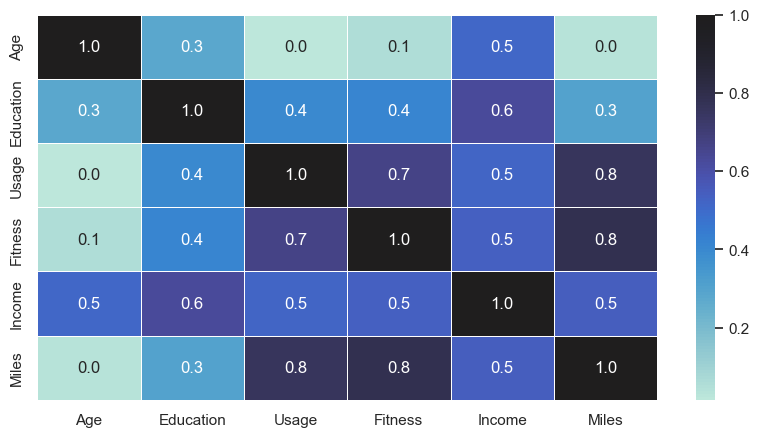

In [56]:
# Vẽ bản đồ của ma trận tương quan
plt.figure(figsize=(10,5))
sns.heatmap(corr_pd, annot=True, linewidths=.5, fmt= '.1f', center = 1)
plt.show()

# __Ver 2: Vẽ trực tiếp không chuyển Pandas__

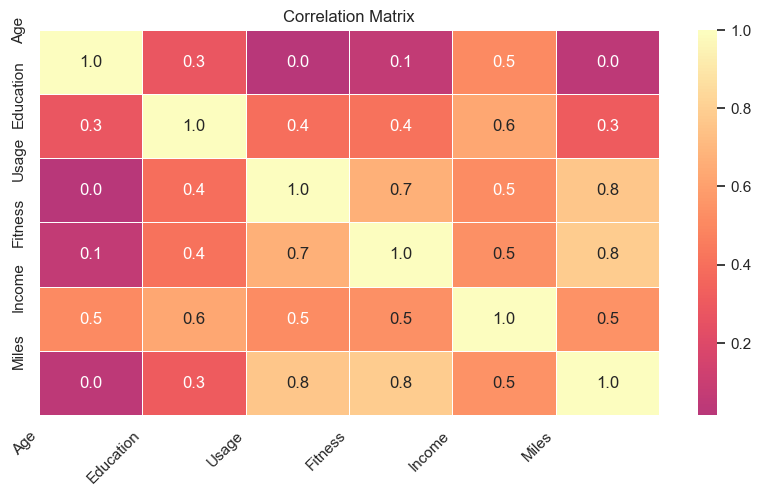

In [57]:
# Get the correlation matrix values as a numpy array
corr_matrix_np = corr_matrix.toArray()

# Get the column names
column_names = cols

# Create a figure and axes
plt.figure(figsize=(10, 5))

# Vẽ bản đồ của ma trận tương quan
sns.heatmap(corr_matrix_np, cmap='magma', annot=True, linewidths=.5, fmt='.1f', center=0)

plt.xticks(range(len(column_names)), column_names, rotation=45, ha='right')
plt.yticks(range(len(column_names)), column_names)
plt.title('Correlation Matrix')

# Display the plot
plt.show()

# __Ver 3: Dùng Matplotliib vẽ__

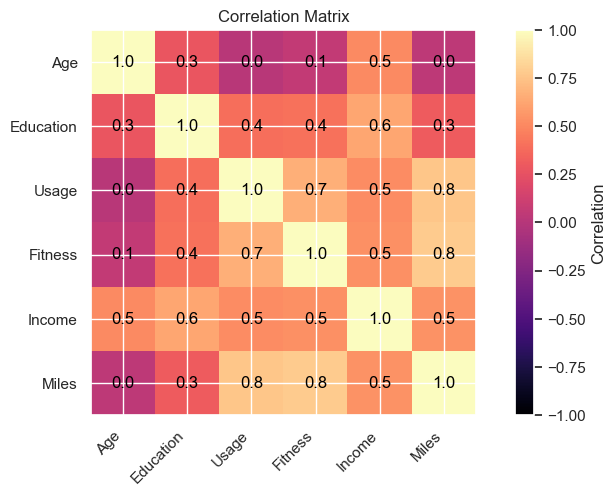

In [58]:
# Get the correlation matrix values as a numpy array
corr_matrix_np = corr_matrix.toArray()

# Get the column names
column_names = cols

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Create the heatmap
heatmap = ax.imshow(corr_matrix_np, cmap='magma', vmin=-1, vmax=1)

# Set the tick labels and positions
ax.set_xticks(np.arange(len(column_names)))
ax.set_yticks(np.arange(len(column_names)))
ax.set_xticklabels(column_names, rotation=45, ha='right')
ax.set_yticklabels(column_names)

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('Correlation')

# Add annotations
for i in range(len(column_names)):
    for j in range(len(column_names)):
        text = ax.text(j, i, '{:.1f}'.format(corr_matrix_np[i, j]),
                       ha='center', va='center', color='black')

# Set title
ax.set_title('Correlation Matrix')

# Display the plot
plt.show()


# __Regression techniques — Fitness Prediction__

- __assembler = VectorAssembler(inputCols=['Usage', 'Fitness'], outputCol='features')__ : biến đổi các cột đầu vào thành một cột đầu ra duy nhất

- __train, test = df.randomSplit([0.7, 0.3], seed=0)__ : Chia dữ liệu thành hai tập huấn luyện và kiểm tra với tỷ lệ 70:30, mỗi lần chia dữ liệu sẽ tạo ra các kết quả khác nhau tùy thuộc vào giá trị của tham số __seed__

- __label_indexer = StringIndexer(inputCol='Miles', outputCol='label').fit(df)__ :  Biến đổi cột nhãn Miles từ dạng chuỗi sang dạng số bằng cách sử dụng StringIndexer

- Input: Dữ liệu cột Usage, Fitness

- Output: một mô hình biến đổi, có thể được áp dụng lên tập dữ liệu để biến đổi cột nhãn thành các giá trị số

In [59]:
# Tạo vector
assembler = VectorAssembler(inputCols=['Usage', 'Fitness'], outputCol='features')

# Chia dữ liệu
train, test = df.randomSplit([0.7, 0.3], seed=0)

# chuyển đổi dữ liệu
label_indexer = StringIndexer(inputCol='Miles', outputCol='label').fit(df)
train = label_indexer.transform(train)
test = label_indexer.transform(test)

# __Linear Regression__

- __lr = LinearRegression(featuresCol='features', labelCol='Miles')__ :Khởi tạo mô hình __Linear Regression__, với cột đặc trưng là __features__ và cột nhãn là __Miles__

- __lr_model = lr.fit(assembler.transform(train))__ : Huấn luyện mô hình Linear Regression trên dữ liệu train

- __lr_predictions = lr_model.transform(assembler.transform(test))__ : Huấn luyện mô hình Linear Regression trên dữ liệu test

- __lr_evaluator = RegressionEvaluator(labelCol='Miles', predictionCol='prediction', metricName='r2')__ : Khởi tạo một đối tượng RegressionEvaluator để đánh giá mô hình Linear Regression

- __lr_score = lr_evaluator.evaluate(lr_predictions)__ : Đánh giá mô hình Linear Regression bằng độ đo R-squared

- __print('The R-squared score of Linear Regression is:', lr_score)__ : ghi giá trị đã tính được

In [60]:
# Linear Regression
lr = LinearRegression(featuresCol='features', labelCol='Miles')
lr_model = lr.fit(assembler.transform(train))
lr_predictions = lr_model.transform(assembler.transform(test))

lr_evaluator = RegressionEvaluator(labelCol='Miles', predictionCol='prediction', metricName='r2')
lr_score = lr_evaluator.evaluate(lr_predictions)
print('The R-squared score of Linear Regression is:', lr_score)

The R-squared score of Linear Regression is: 0.7992094340052229


# __Logistic Regression__

- __lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)__ : khởi tạo mô hình LogisticRegression với các tham số featuresCol là tên cột chứa các đặc trưng, labelCol là tên cột chứa nhãn, và maxIter là số lần lặp lại tối đa để huấn luyện mô hình

- __lr_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')__ : sử dụng đối tượng MulticlassClassificationEvaluator để tính toán độ chính xác của mô hình

In [61]:
# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lr_model = lr.fit(assembler.transform(train))
lr_predictions = lr_model.transform(assembler.transform(test))

lr_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
lr_score = lr_evaluator.evaluate(lr_predictions)
print('The accuracy of Logistic Regression is:', lr_score)

The accuracy of Logistic Regression is: 0.1276595744680851


# __Decision Tree Classifier__

- __dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')__ : input là 'features' và output là 'label' (cột "Miles" đã được chuyển đổi thành cột số như trước đó)

- __dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')__ : đánh giá độ chính xác của mô hình Decision Tree Classifier

In [62]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
dt_model = dt.fit(assembler.transform(train))
dt_predictions = dt_model.transform(assembler.transform(test))

dt_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print('The accuracy of Decision Tree Classifier is:', dt_accuracy)

The accuracy of Decision Tree Classifier is: 0.1276595744680851
